In [29]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx   #library to model graphs. Cool because can tell you which nodes are neighbours to the other.
from linopy import Model
from itertools import combinations

# Import Data

In [30]:
#Import data on conductors
conductors_df = pd.read_csv("./cables_types.csv", index_col=0)
conductors = conductors_df.to_xarray()

#Import data on Buses
Bus_pos_df = pd.read_csv("./buses.csv", index_col=0)
Bus_position = Bus_pos_df.to_xarray()


day = 56
#Import data on days considered.
if day == 56:
    P_demand_df = pd.read_csv("./P_demand_Buses_winter.csv",index_col=0)
    Q_demand_df = pd.read_csv("./Q_demand_Buses_winter.csv",index_col=0)
elif day == 93:
    P_demand_df = pd.read_csv("./P_demand_Buses_spring.csv",index_col=0)
    Q_demand_df = pd.read_csv("./Q_demand_Buses_spring.csv",index_col=0)
elif day == 201:
    P_demand_df = pd.read_csv("./P_demand_Buses_summer.csv",index_col=0)
    Q_demand_df = pd.read_csv("./Q_demand_Buses_xummer.csv",index_col=0)
else:
    print("error : chosen day not in the data.")

P_demand = P_demand_df.to_xarray()
Q_demand = Q_demand_df.to_xarray()

    

# Initiating the bus topology

In [31]:
#Helping functions :
def plot(G, title="Graph"):
    pos = nx.get_node_attributes(G, 'pos')
    if not pos:
        print("No position data found.")
    else:
        plt.figure(figsize=(6, 6))
        nx.draw(G, pos, with_labels=True, node_size=300, alpha=0.8, arrows=True)
        plt.title(title)
        plt.gca().set_aspect('equal')
        plt.show()

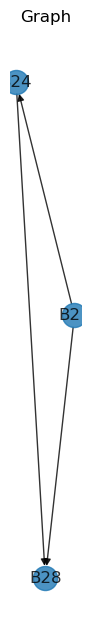

In [32]:
#Bus geometry implementation
Bus_ID = Bus_position["Building ID"].values
X = Bus_position["X"].values/100
Y = - Bus_position["Y"].values/100
network_voltage = Bus_position["Voltage"].values
zone = Bus_position["zone"].values

G_04_Hochelaga = nx.DiGraph()
for i in range(len(Bus_ID)):
    bus_id = Bus_ID[i]
    pos = (X[i], Y[i])
    voltage = network_voltage[i]
    current_zone = zone[i]
    if voltage == 0.4 and current_zone == "Hochelaga":
        G_04_Hochelaga.add_node(bus_id, P=0.0, pos=pos)



        # Add edges between all nodes 
for u, v in combinations(G_04_Hochelaga.nodes, 2):
    G_04_Hochelaga.add_edge(u, v)
    
plot(G_04_Hochelaga)

In [33]:
list(G_04_Hochelaga.nodes)[0]

'B22'

# Create the sets and parameters   of the linopy model

In [34]:
### Sets
time = P_demand.get_index("Date/Time")

# Lines
line_list = list(G_04_Hochelaga.edges)
line_index = pd.MultiIndex.from_tuples(line_list, names=["from_bus", "to_bus"])
lines = xr.DataArray(
    data=line_index,  # dummy values are fine here, just to match shape
    coords={"Lines": line_index},
    dims="Lines"
)
from_bus = xr.DataArray(
    line_index.get_level_values("from_bus"),
    coords={"Lines": lines.coords["Lines"]},  # original Lines coord
    dims="Lines"
)

to_bus = xr.DataArray(
    line_index.get_level_values("to_bus"),
    coords={"Lines": lines.coords["Lines"]},
    dims="Lines"
)

# Buses and substation
buses = pd.Index(G_04_Hochelaga.nodes, name = "Buses")
buses = xr.DataArray(buses, dims="Buses", name="Buses")
is_substation = pd.Series(buses.isin(['B22']), index=buses, name='is_substation') #Choisi manuellement dans un premier temps
substation_xr = xr.DataArray(is_substation, coords=[buses])
substations = substation_xr.where(substation_xr, drop=True).coords["Buses"].values
substations = xr.DataArray(substations, dims="Substations", name="Substations")
#Conductors
types = conductors.get_index("Conductor_type")

# Days (d'abord un par un, on verra plus tard pour le vrai day.)
#days = [1]



### Parameters
# Time related
PLANNING_HORIZON = 20 
HOURS_PER_YEAR = 8760

# Cost related

TAUL =  0.05             
TAUS =  0.05     

KC = 0.08                 
KL = (TAUL * (TAUL+1)**PLANNING_HORIZON)/(((TAUL+1)**PLANNING_HORIZON) -1)                  
KS= (TAUS * (TAUS+1)**PLANNING_HORIZON)/(((TAUS+1)**PLANNING_HORIZON) -1)                   # vient de i(i+1)^n/((i+1)^n -1)
               
CF = 1000               # paper data
CSI = 350000               # false data
CVI = 1e-5               # false data
cost_line = 100000                # false data
CUN  = 500              # false data
CK  = 100000              # false data
CL = 0.0781                # false data


# type related
R = conductors['Resistance']
X = conductors['Reactance']
Z = R**2 + X**2


# Line related
positions = nx.get_node_attributes(G_04_Hochelaga, "pos")
edge_lengths = []
for i,j in G_04_Hochelaga.edges:
    xi, yi = positions[i]
    xj, yj = positions[j]
    length = np.sqrt((xi - xj)**2 + (yi - yj)**2)
    edge_lengths.append((i,j,length))
line_index = pd.MultiIndex.from_tuples([(i, j) for i, j, _ in edge_lengths], names=["from_bus", "to_bus"])
lengths = [length for _, _, length in edge_lengths]
LENGTH = xr.DataArray(lengths, coords={"Lines": line_index},dims="Lines", name="line_length")


# Voltage related
V_MIN = 0.9
V_MAX = 1.1
B_MAX = 0.2

# Current related
I_MAX = conductors['I_MAX']

# Capacitor related
N_CAP_MAX = 100                # false data
N_CAP_TOTAL = 10e6               # false data
Q_PER_CAP = 1e6                      # e.g., 1 MVAr per unit

# Power related
SG = 10e6                   # false data
CS = 215*SG

P_D_LIST = []
Q_D_LIST = []
for i in buses.values:
    P_D_LIST.append((i, P_demand[i]))
    Q_D_LIST.append((i, Q_demand[i]))
P_D_dict = {bus: da for bus, da in P_D_LIST}
Q_D_dict = {bus: da for bus, da in Q_D_LIST}
# Convert to a single DataArray with stacked dimension: (Bus, Date/Time)
P_DEMAND = xr.concat(P_D_dict.values(), dim=pd.Index(P_D_dict.keys(), name="Buses"))
Q_DEMAND = xr.concat(Q_D_dict.values(), dim=pd.Index(Q_D_dict.keys(), name="Buses"))


P_GEN = xr.zeros_like(P_DEMAND)
p_charge = xr.zeros_like(P_DEMAND)
p_discharge = xr.zeros_like(P_DEMAND)

### Write the optimization model (variables, constraints and objective function)

In [39]:
### model instance
m = Model()

### Variables
# Courants (I²)
i_squared_cond = m.add_variables(name="i_squared_cond", coords=[lines, time, types])
i_squared = m.add_variables(name="i_squared", coords=[lines, time])

# Tensions (V²)
v_squared =  m.add_variables(name="v_squared", coords=[buses, time])

# Puissance apparente au niveau des sous-stations (S²)
s_sub_squared = m.add_variables(name="s_sub_squared", coords=[substations, time])

# Flux de puissance actif/réactif sur les lignes par conducteur
p_flow = m.add_variables(name="p_flow", coords=[lines, time, types])
q_flow = m.add_variables(name="q_flow", coords=[lines, time, types])

# Flux de puissance total (somme des conducteurs)
p_flow_total = m.add_variables(name="p_flow_total", coords=[lines, time])
q_flow_total = m.add_variables(name="q_flow_total", coords=[lines, time])

# Puissance injectée par les sous-stations
p_sub = m.add_variables(name="p_sub", lower =0, coords=[substations, time])
q_sub = m.add_variables(name="q_sub", lower =0, coords=[substations, time])

# Terme de chute de tension
voltage_drop_term = m.add_variables(name="voltage_drop_term", coords=[lines])

# Nombre d’unités de condensateur installées
n_cap = m.add_variables(name="n_cap", coords=[buses], integer=True)
q_cap_installed = m.add_variables(name="q_cap_installed", coords=[buses], binary=True)

# Activité des lignes (directionnelle)
line_active_forward = m.add_variables(name="line_active_forward", coords=[lines, time], binary=True)
line_active_reverse = m.add_variables(name="line_active_reverse", coords=[lines, time], binary=True)

# Sélection du type de conducteur
conductor_selected = m.add_variables(name="conductor_selected", coords=[lines, types], binary=True)

# Sous-stations construites
substation_built = m.add_variables(name="substation_built", coords=[substations], binary=True)


### Constarints
m.add_constraints(p_flow.groupby(to_bus).sum(dim="Lines").sum(dim="Conductor_type")
    - p_flow.groupby(from_bus).sum(dim="Lines").sum(dim="Conductor_type")
    + p_sub
    + P_GEN
    - p_charge
    + p_discharge 
    == P_DEMAND
)

# Reactive Power Balance Constraint
m.add_constraints(
    q_flow.groupby(to_bus).sum(dim="Lines").sum(dim="Conductor_type")
    - q_flow.groupby(to_bus).sum(dim="Lines").sum(dim="Conductor_type")
    + q_sub
    + Q_PER_CAP * n_cap
    == Q_DEMAND
)

# Voltage drop
V_from = v_squared.sel(Buses=from_bus)
V_to = v_squared.sel(Buses=to_bus)
drop_expr = (
    2 * (R * p_flow + X * q_flow) * LENGTH +
    Z**2 * LENGTH**2 * i_squared_cond
).sum(dim="Conductor_type")
m.add_constraints(
    V_from - V_to == voltage_drop_term + drop_expr
)

# Voltage bounds
m.add_constraints(v_squared >= V_MIN**2)
m.add_constraints(v_squared <= V_MAX**2)

# Voltage drop limit using big-M
m.add_constraints(voltage_drop_term <= B_MAX * (-(line_active_forward + line_active_reverse -1)))
m.add_constraints(voltage_drop_term >= -B_MAX * (-(line_active_forward + line_active_reverse -1)))

# Current limit with active line
m.add_constraints(i_squared_cond <= I_MAX**2 * (line_active_forward + line_active_reverse))

# Current limit with selected conductor
m.add_constraints(i_squared_cond <= I_MAX**2 * conductor_selected)

# Quadratic relation for power flow (relaxed to SOCP form if needed)
V_to = v_squared.sel(Buses=to_bus)
#m.add_constraints(V_to * i_squared >= p_flow_total**2 + q_flow_total**2)   # GROS PROBLEME, LINOPY N ACCEPTE PAS LES EXPRESSIONS QUADRATIQUES...
m.add_constraints(i_squared <= I_MAX**2)

# Power flow bounds with direction
m.add_constraints(p_flow <= V_MAX * I_MAX * line_active_forward)
m.add_constraints(p_flow >= -V_MAX * I_MAX * line_active_reverse)
m.add_constraints(q_flow <= V_MAX * I_MAX * (line_active_forward + line_active_reverse))
m.add_constraints(q_flow >= -V_MAX * I_MAX * (line_active_forward + line_active_reverse))


# Power flow limit with conductor
m.add_constraints(p_flow <= V_MAX * I_MAX * conductor_selected)
m.add_constraints(p_flow >= -V_MAX * I_MAX * conductor_selected)
m.add_constraints(q_flow <= V_MAX * I_MAX * conductor_selected)
m.add_constraints(q_flow >= -V_MAX * I_MAX * conductor_selected)

# Substation apparent power constraint
m.add_constraints(s_sub_squared >= p_sub**2 + q_sub**2)

# Substation capacity limit
m.add_constraints(s_sub_squared <= SG**2 * substation_built)

# Capacitor constraints
m.add_constraints(n_cap <= N_CAP_MAX * q_cap_installed)
m.add_constraints(q_cap_installed.sum(dims ="Buses") <= N_CAP_TOTAL)

# Total current as sum of conductor currents
m.add_constraints(i_squared == i_squared_cond.sum(dims ="Conductor_type"))

# Total active power as sum of conductor-specific power flows
m.add_constraints(p_flow_total == p_flow.sum(dims ="Conductor_type"))

# Total reactive power as sum of conductor-specific reactive flows
m.add_constraints(q_flow_total == q_flow.sum(dims ="Conductor_type"))

# One direction only per line
m.add_constraints(line_active_forward + line_active_reverse <= 1)

# Radiality: total number of active lines equals buses - substations
m.add_constraints((line_active_forward + line_active_reverse).sum(dims="Lines") == len(buses) - len(substations))

# Unique conductor per line if line is active
m.add_constraints(conductor_selected.sum(dims = "Conductor_type") == line_active_forward + line_active_reverse)



# Capital recovery factor (can be calculated outside)
crf_s = (1 - (1 + TAUS) ** -PLANNING_HORIZON) / TAUS
crf_l = (1 - (1 + TAUL) ** -PLANNING_HORIZON) / TAUL

# Substation cost
substation_cost = (
    KS * CSI * substation_built
    + (HOURS_PER_YEAR / 72) * crf_s * CVI * s_sub_squared.sum(dims ="Date/Time")
).sum(dims = "Substations")

# Line cost
line_losses = i_squared.sum(dims = "Date/Time") * R * LENGTH * CL
line_cost = (
    KL * cost_line * conductor_selected
    + (HOURS_PER_YEAR / 72) * crf_l * line_losses
).sum(dims= ["Lines", "Conductor_type"])

# Capacitor cost
capacitor_cost = (CK * q_cap_installed + CUN * n_cap).sum(dims = "Buses")

# Total objective
m.objective = substation_cost + line_cost + capacitor_cost

In [40]:
m.solve("gurobi")

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2551043
Academic license 2551043 - for non-commercial use only - registered to p.___@uliege.be
Read LP format model from file /tmp/linopy-problem-7hpfmf13.lp
Reading time = 0.01 seconds
obj: 3628 rows, 1171 columns, 10185 nonzeros
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: Intel(R) Xeon(R) Gold 6354 CPU @ 3.00GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Academic license 2551043 - for non-commercial use only - registered to p.___@uliege.be
Optimize a model with 3628 rows, 1171 columns and 10185 nonzeros
Model fingerprint: 0xda05d6b1
Variable types: 1011 continuous, 160 integer (157 binary)
Coefficient statistics:
  Matrix range     [9e-05, 1e+14]
  Objective range  [2e-02, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 1e+07]
         Consider reformulating model 

Optimization potentially failed: 
Status: warning
Termination condition: infeasible_or_unbounded
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: 4



('warning', 'infeasible_or_unbounded')